2016 0 10079


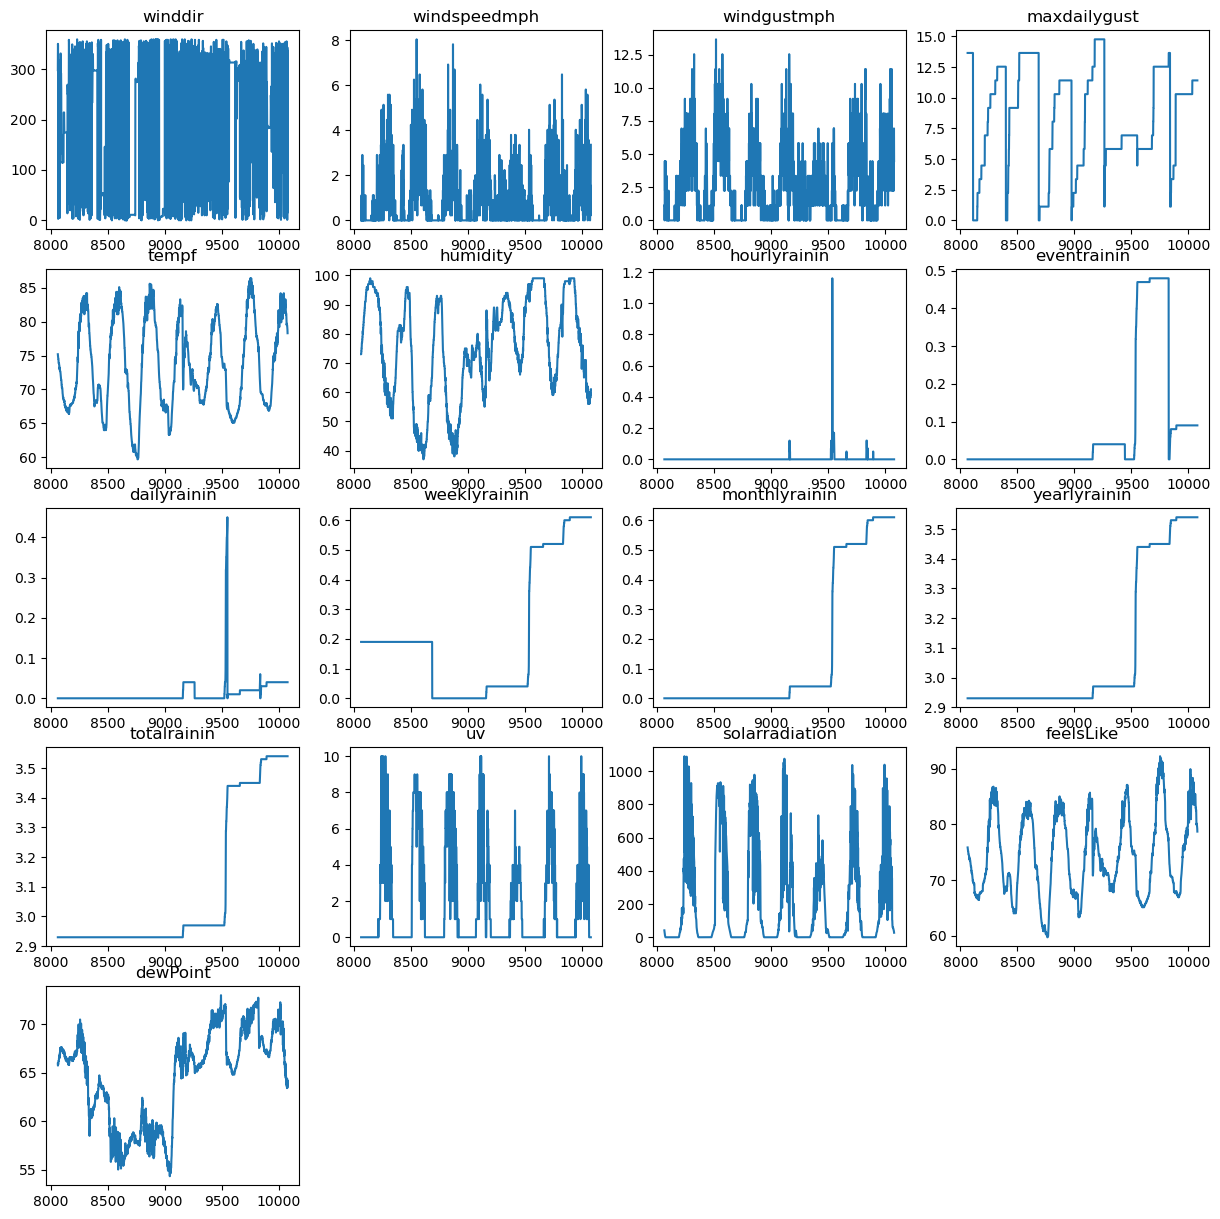

Done


In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, interp1d
from datetime import datetime
from math import floor
import matplotlib.pyplot as plt
from BEE_WEATHER_DATA import BROODMINDER_GET, AMBIENT_GET, READ_HIVE, PROCESS_HIVE, READ_BEE_WEATHER, PROCESS_BEE_WEATHER, PROCESS_AMBIENT

hive_name = "New Left Hive"
Data, len1, len2 = PROCESS_AMBIENT()
#Data, len1, len2 = PROCESS_BEE_WEATHER()
#Data, len1, len2 = PROCESS_HIVE(hive_name)
print(len(Data), len1, len2)

def Graph_Data(Data): #Pandas DF
    metrics = [i for i in list(Data.keys()) if not i == "dateutc" and not i == "lastRain" and not i == "Unix_Time"]
    metric_num = len(metrics)
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.2)

    ncols = 4
    nrows = metric_num // ncols + (metric_num % ncols > 0)

    for i, match in enumerate(metrics):
        ax = plt.subplot(nrows, ncols, i + 1)
        Data[str(match)].plot(ax=ax)
        ax.set_title(str(match))
    plt.show()

Graph_Data(Data)

print("Done")

In [2]:
 print(len(Data))

856715
